# Paper ST Sloping - Multi Classification Start

## Setup

In [1]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced, specificity_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import all_estimators
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
mpl.rcParams["figure.figsize"] = (12, 5)
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
THREADS_TO_USE = 4

## Load dataset

In [4]:
data = pd.read_csv('dataset/st_dataset_10beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,39.341333,39.831764,39.826684,11.282887,1.634628,0.913825,-0.771782,-1.359522,-0.634856,...,-0.049375,0.037769,-0.045755,0.051531,-0.078515,0.013704,-0.024545,-0.017430,0.001676,NSR
1,e0106,43.320409,45.006516,44.365681,12.474802,1.826689,0.901002,-0.707731,-1.281504,-0.731562,...,-0.033106,0.009999,-0.014494,0.028882,-0.048873,-0.010926,-0.026088,0.009880,-0.021702,NSR
2,e0106,41.841597,41.778007,41.593833,11.837152,1.721631,0.911361,-0.728350,-1.293684,-0.729167,...,-0.049280,0.038759,-0.048515,0.056363,-0.076889,-0.002209,-0.011804,-0.015943,-0.006355,NSR
3,e0106,43.146961,41.264063,41.075821,11.843259,1.752020,0.906516,-0.728333,-1.275260,-0.678176,...,-0.065776,0.050750,-0.050526,0.048861,-0.084336,0.026353,-0.035720,-0.018588,0.013943,NSR
4,e0106,41.647822,43.131905,43.437246,12.388259,1.809692,0.915806,-0.758906,-1.398698,-0.864005,...,-0.049441,0.035196,-0.047893,0.061977,-0.082722,0.004341,-0.018094,-0.013906,-0.001004,NSR


NSR    41933
ST-     8802
ST+     3950
Name: label, dtype: int64


(array([41933.,     0.,     0.,     0.,     0.,  8802.,     0.,     0.,
            0.,  3950.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

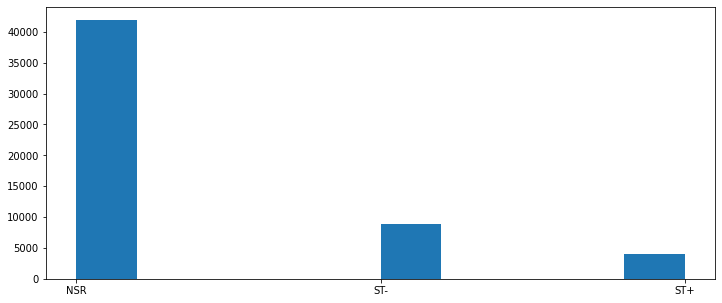

In [5]:
print(data['label'].value_counts())
plt.hist(data['label'])

In [6]:
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()
y = data['label'].values

In [7]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [8]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [9]:
print(correlated_features)

{'fft_200', 'mfw_5', 'fft_227', 'mfw_13', 'mfw_15', 'fft_198', 'cfr_16', 'fft_232', 'fft_243', 'fft_221', 'fft_218', 'fft_210', 'fft_139', 'fft_161', 'fft_168', 'fft_246', 'fft_237', 'fft_144', 'fft_191', 'fft_233', 'fft_228', 'fft_193', 'fft_203', 'fft_178', 'fft_138', 'fft_132', 'fft_143', 'fft_169', 'fft_134', 'fft_223', 'fft_235', 'fft_152', 'fft_154', 'fft_213', 'fft_130', 'fft_136', 'mfw_12', 'fft_149', 'fft_231', 'mfw_14', 'fft_153', 'fft_186', 'fft_240', 'fft_245', 'mfw_10', 'fft_131', 'fft_170', 'fft_166', 'fft_249', 'fft_174', 'fft_234', 'fft_172', 'fft_222', 'fft_192', 'fft_225', 'fft_220', 'fft_195', 'fft_241', 'fft_209', 'fft_146', 'fft_179', 'fft_196', 'fft_212', 'fft_157', 'mfw_11', 'fft_159', 'fft_180', 'fft_215', 'fft_239', 'fft_147', 'fft_135', 'fft_255', 'fft_175', 'fft_184', 'mfw_16', 'fft_219', 'fft_236', 'fft_242', 'fft_173', 'fft_204', 'fft_224', 'fft_160', 'fft_190', 'fft_188', 'mfw_6', 'fft_185', 'fft_256', 'mfw_8', 'fft_140', 'fft_208', 'fft_155', 'fft_214', '

### Random forest embeded for features selection

In [10]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [11]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [12]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 77


### Visualization best features

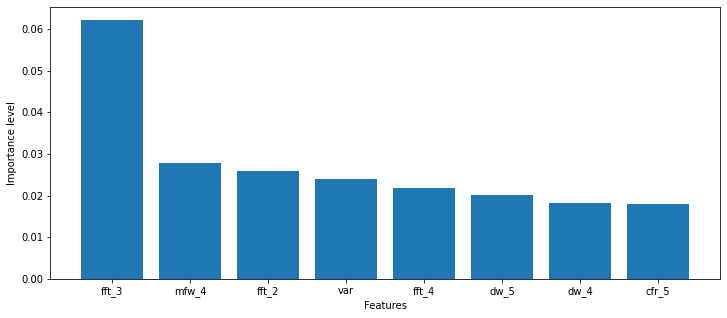

In [13]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [14]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,39.341333,39.831764,39.826684,11.282887,1.634628,0.913825,-0.771782,-1.359522,-0.634856,0.232364,...,0.019450,0.044698,-0.049375,0.037769,-0.045755,0.051531,-0.078515,0.013704,-0.024545,-0.017430
1,43.320409,45.006516,44.365681,12.474802,1.826689,0.901002,-0.707731,-1.281504,-0.731562,-1.393341,...,0.013422,0.040336,-0.033106,0.009999,-0.014494,0.028882,-0.048873,-0.010926,-0.026088,0.009880
2,41.841597,41.778007,41.593833,11.837152,1.721631,0.911361,-0.728350,-1.293684,-0.729167,-1.923488,...,0.010183,0.036844,-0.049280,0.038759,-0.048515,0.056363,-0.076889,-0.002209,-0.011804,-0.015943
3,43.146961,41.264063,41.075821,11.843259,1.752020,0.906516,-0.728333,-1.275260,-0.678176,-1.560684,...,0.001683,0.048352,-0.065776,0.050750,-0.050526,0.048861,-0.084336,0.026353,-0.035720,-0.018588
4,41.647822,43.131905,43.437246,12.388259,1.809692,0.915806,-0.758906,-1.398698,-0.864005,4.788369,...,0.015460,0.047792,-0.049441,0.035196,-0.047893,0.061977,-0.082722,0.004341,-0.018094,-0.013906


## Load classifiers

In [15]:
classifiers_from_lib = all_estimators(type_filter='classifier')
print(classifiers_from_lib)

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('ClassifierChain', <class 'sklearn.multioutput.ClassifierChain'>), ('ComplementNB', <class 'sklearn.naive_bayes.ComplementNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('GaussianProcessClassifier', <class 'sklearn.gaussian_process._gpc.GaussianProcessClassifier'>), ('GradientBoostingClassifier', <cl

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

classifiers = [
    AdaBoostClassifier(),
    DecisionTreeClassifier(),
    DummyClassifier(),
    ExtraTreeClassifier(),
    KNeighborsClassifier(n_jobs=THREADS_TO_USE),
    LinearDiscriminantAnalysis(),
    LinearSVC(),
    LogisticRegression(n_jobs=THREADS_TO_USE),
    MLPClassifier(),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(n_jobs=THREADS_TO_USE),
    SVC()
]

## No Sampling

In [17]:
df_no_sampling = pd.DataFrame(columns=['algo', 'accuracy', 'specificity', 'precision', 'recall', 'f1',])

x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2)
for classifier in classifiers:
    print(classifier)
    model = classifier.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # Print metrics
    print(pd.crosstab(y_test_dec, y_pred_dec, rownames=['Actual'], colnames=['Predicted']))
    print('\n')
    print(classification_report(y_test_dec, y_pred_dec))
    print('\n')
    print(classification_report_imbalanced(y_test_dec, y_pred_dec))

    # Parse metrics
    report = classification_report(y_true=y_test_dec, y_pred=y_pred_dec, output_dict=True)
    specificity = specificity_score(y_true=y_test_dec, y_pred=y_pred_dec, average="weighted")

    acc = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    df_no_sampling = df_no_sampling.append({
        "algo": str(classifier)[:str(classifier).index("(")],
        "accuracy": acc,
        "specificity": specificity,
        "precision": precision,
        "recall": recall,
        "f1": f1
     }, ignore_index=True)

AdaBoostClassifier()
Predicted   NSR  ST+  ST-
Actual                   
NSR        7628  267  486
ST+         404  379    9
ST-         984    5  775


              precision    recall  f1-score   support

         NSR       0.85      0.91      0.88      8381
         ST+       0.58      0.48      0.53       792
         ST-       0.61      0.44      0.51      1764

    accuracy                           0.80     10937
   macro avg       0.68      0.61      0.64     10937
weighted avg       0.79      0.80      0.79     10937



                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.85      0.91      0.46      0.88      0.64      0.43      8381
        ST+       0.58      0.48      0.97      0.53      0.68      0.44       792
        ST-       0.61      0.44      0.95      0.51      0.64      0.39      1764

avg / total       0.79      0.80      0.57      0.79      0.65      0.43     10937

DecisionTreeClassifier()
Predicted   NSR  ST+ 

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

         NSR       0.77      1.00      0.87      8381
         ST+       0.00      0.00      0.00       792
         ST-       0.00      0.00      0.00      1764

    accuracy                           0.77     10937
   macro avg       0.26      0.33      0.29     10937
weighted avg       0.59      0.77      0.66     10937



                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.77      1.00      0.00      0.87      0.00      0.00      8381
        ST+       0.00      0.00      1.00      0.00      0.00      0.00       792
        ST-       0.00      0.00      1.00      0.00      0.00      0.00      1764

avg / total       0.59      0.77      0.23      0.66      0.00      0.00     10937



c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

ExtraTreeClassifier()
Predicted   NSR  ST+   ST-
Actual                    
NSR        7428  232   721
ST+         246  511    35
ST-         696   31  1037


              precision    recall  f1-score   support

         NSR       0.89      0.89      0.89      8381
         ST+       0.66      0.65      0.65       792
         ST-       0.58      0.59      0.58      1764

    accuracy                           0.82     10937
   macro avg       0.71      0.71      0.71     10937
weighted avg       0.82      0.82      0.82     10937



                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.89      0.89      0.63      0.89      0.75      0.57      8381
        ST+       0.66      0.65      0.97      0.65      0.79      0.61       792
        ST-       0.58      0.59      0.92      0.58      0.73      0.52      1764

avg / total       0.82      0.82      0.70      0.82      0.75      0.57     10937

KNeighborsClassifier(n_jobs=4)
Predicted

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Predicted   NSR  ST+   ST-
Actual                    
NSR        2880  660  4841
ST+         101  398   293
ST-         134   45  1585


              precision    recall  f1-score   support

         NSR       0.92      0.34      0.50      8381
         ST+       0.36      0.50      0.42       792
         ST-       0.24      0.90      0.37      1764

    accuracy                           0.44     10937
   macro avg       0.51      0.58      0.43     10937
weighted avg       0.77      0.44      0.47     10937



                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.92      0.34      0.91      0.50      0.56      0.29      8381
        ST+       0.36      0.50      0.93      0.42      0.68      0.45       792
        ST-       0.24      0.90      0.44      0.37      0.63      0.41      1764

avg / total       0.77      0.44      0.83      0.47      0.58      0.32     10937

LogisticRegression(n_jobs=4)
Predicted   NSR  ST+  ST-
Actual 

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.80      0.99      0.19      0.89      0.44      0.21      8381
        ST+       0.00      0.00      1.00      0.00      0.00      0.00       792
        ST-       0.84      0.28      0.99      0.41      0.52      0.25      1764

avg / total       0.75      0.80      0.38      0.75      0.42      0.20     10937



c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

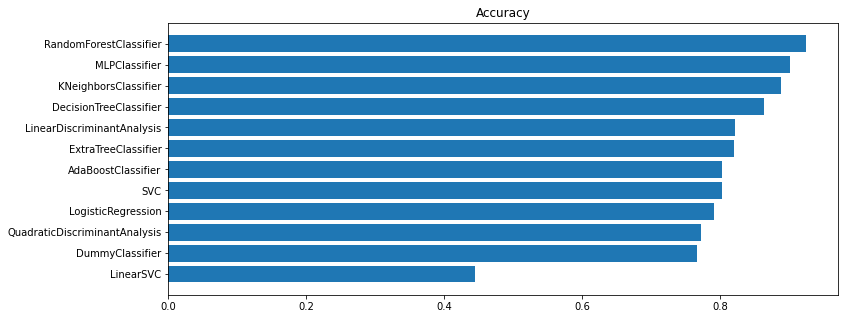

In [18]:
df_no_sampling.sort_values(by=['accuracy'], inplace=True)
plt.barh(df_no_sampling['algo'], df_no_sampling['accuracy'])
plt.title("Accuracy")
plt.savefig("run_all_multi_result_img/no_sampling_accuracy.png", bbox_inches = 'tight')
plt.show()

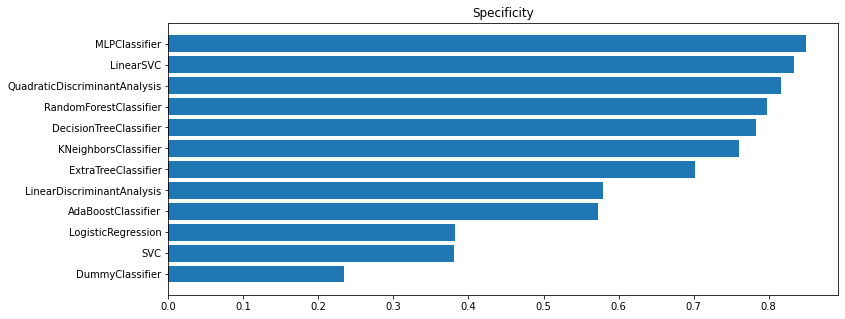

In [19]:
df_no_sampling.sort_values(by=['specificity'], inplace=True)
plt.barh(df_no_sampling['algo'], df_no_sampling['specificity'])
plt.title("Specificity")
plt.savefig("run_all_multi_result_img/no_sampling_specificity.png", bbox_inches = 'tight')
plt.show()

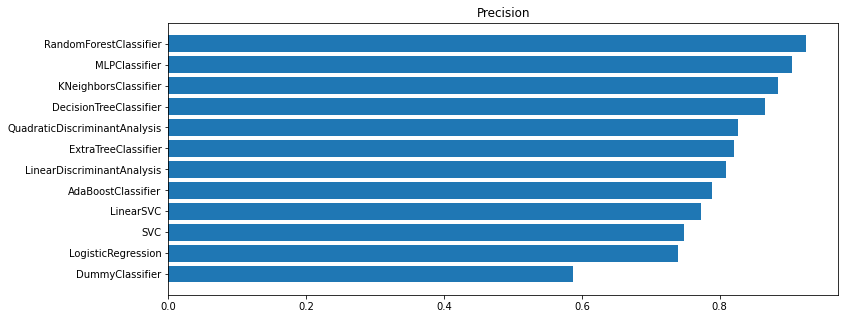

In [20]:
df_no_sampling.sort_values(by=['precision'], inplace=True)
plt.barh(df_no_sampling['algo'], df_no_sampling['precision'])
plt.title("Precision")
plt.savefig("run_all_multi_result_img/no_sampling_precision.png", bbox_inches = 'tight')
plt.show()

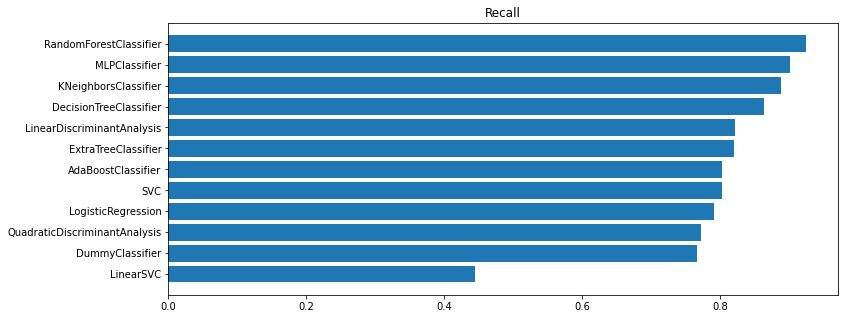

In [21]:
df_no_sampling.sort_values(by=['recall'], inplace=True)
plt.barh(df_no_sampling['algo'], df_no_sampling['recall'])
plt.title("Recall")
plt.savefig("run_all_multi_result_img/no_sampling_recall.png", bbox_inches = 'tight')
plt.show()

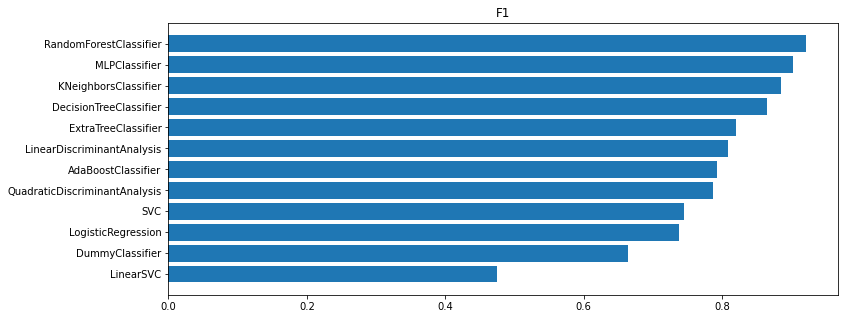

In [22]:
df_no_sampling.sort_values(by=['f1'], inplace=True)
plt.barh(df_no_sampling['algo'], df_no_sampling['f1'])
plt.title("F1")
plt.savefig("run_all_multi_result_img/no_sampling_f1.png", bbox_inches = 'tight')
plt.show()

# SMOTE sampling

In [23]:
df_smote_sampling = pd.DataFrame(columns=['algo', 'accuracy', 'specificity', 'precision', 'recall', 'f1',])

x_smote, y_smote = SMOTE().fit_resample(X_fsel, y)
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2)
for classifier in classifiers:
    print(classifier)
    model = classifier.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # Print metrics
    print(pd.crosstab(y_test_dec, y_pred_dec, rownames=['Actual'], colnames=['Predicted']))
    print('\n')
    print(classification_report(y_test_dec, y_pred_dec))
    print('\n')
    print(classification_report_imbalanced(y_test_dec, y_pred_dec))

    # Parse metrics
    report = classification_report(y_true=y_test_dec, y_pred=y_pred_dec, output_dict=True)
    specificity = specificity_score(y_true=y_test_dec, y_pred=y_pred_dec, average="weighted")

    acc = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    df_smote_sampling = df_smote_sampling.append({
        "algo": str(classifier)[:str(classifier).index("(")],
        "accuracy": acc,
        "specificity": specificity,
        "precision": precision,
        "recall": recall,
        "f1": f1
     }, ignore_index=True)

AdaBoostClassifier()
Predicted   NSR   ST+   ST-
Actual                     
NSR        5117   977  2241
ST+         937  7326   203
ST-        1859   234  6266


              precision    recall  f1-score   support

         NSR       0.65      0.61      0.63      8335
         ST+       0.86      0.87      0.86      8466
         ST-       0.72      0.75      0.73      8359

    accuracy                           0.74     25160
   macro avg       0.74      0.74      0.74     25160
weighted avg       0.74      0.74      0.74     25160



                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.65      0.61      0.83      0.63      0.72      0.50      8335
        ST+       0.86      0.87      0.93      0.86      0.90      0.80      8466
        ST-       0.72      0.75      0.85      0.73      0.80      0.63      8359

avg / total       0.74      0.74      0.87      0.74      0.80      0.64     25160

DecisionTreeClassifier()
Predicted  

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

         NSR       0.33      1.00      0.50      8335
         ST+       0.00      0.00      0.00      8466
         ST-       0.00      0.00      0.00      8359

    accuracy                           0.33     25160
   macro avg       0.11      0.33      0.17     25160
weighted avg       0.11      0.33      0.16     25160





c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.33      1.00      0.00      0.50      0.00      0.00      8335
        ST+       0.00      0.00      1.00      0.00      0.00      0.00      8466
        ST-       0.00      0.00      1.00      0.00      0.00      0.00      8359

avg / total       0.11      0.33      0.67      0.16      0.00      0.00     25160



c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

ExtraTreeClassifier()
Predicted   NSR   ST+   ST-
Actual                     
NSR        6755   416  1164
ST+         243  8142    81
ST-         864    75  7420


              precision    recall  f1-score   support

         NSR       0.86      0.81      0.83      8335
         ST+       0.94      0.96      0.95      8466
         ST-       0.86      0.89      0.87      8359

    accuracy                           0.89     25160
   macro avg       0.89      0.89      0.89     25160
weighted avg       0.89      0.89      0.89     25160



                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.86      0.81      0.93      0.83      0.87      0.75      8335
        ST+       0.94      0.96      0.97      0.95      0.97      0.93      8466
        ST-       0.86      0.89      0.93      0.87      0.91      0.82      8359

avg / total       0.89      0.89      0.94      0.89      0.91      0.83     25160

KNeighborsClassifier(n_jobs=4)
Pred

c:\users\marco\pycharmprojects\paper-st-sloping\venv\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Predicted   NSR   ST+  ST-
Actual                    
NSR        8077   199   59
ST+        5476  2986    4
ST-        7442    31  886


              precision    recall  f1-score   support

         NSR       0.38      0.97      0.55      8335
         ST+       0.93      0.35      0.51      8466
         ST-       0.93      0.11      0.19      8359

    accuracy                           0.47     25160
   macro avg       0.75      0.48      0.42     25160
weighted avg       0.75      0.47      0.42     25160



                   pre       rec       spe        f1       geo       iba       sup

        NSR       0.38      0.97      0.23      0.55      0.47      0.24      8335
        ST+       0.93      0.35      0.99      0.51      0.59      0.33      8466
        ST-       0.93      0.11      1.00      0.19      0.32      0.10      8359

avg / total       0.75      0.47      0.74      0.42      0.46      0.22     25160

LogisticRegression(n_jobs=4)
Predicted   NSR   ST+   ST-
Actua

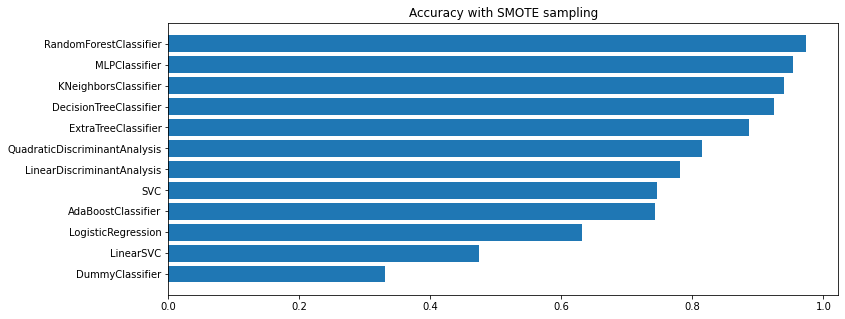

In [24]:
df_smote_sampling.sort_values(by=['accuracy'], inplace=True)
plt.barh(df_smote_sampling['algo'], df_smote_sampling['accuracy'])
plt.title("Accuracy with SMOTE sampling")
plt.savefig("run_all_multi_result_img/smote_accuracy.png", bbox_inches = 'tight')
plt.show()

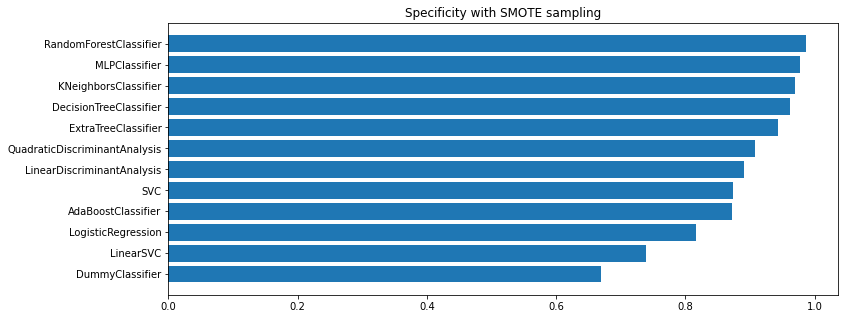

In [25]:
df_smote_sampling.sort_values(by=['specificity'], inplace=True)
plt.barh(df_smote_sampling['algo'], df_smote_sampling['specificity'])
plt.title("Specificity with SMOTE sampling")
plt.savefig("run_all_multi_result_img/smote_specificity.png", bbox_inches = 'tight')
plt.show()

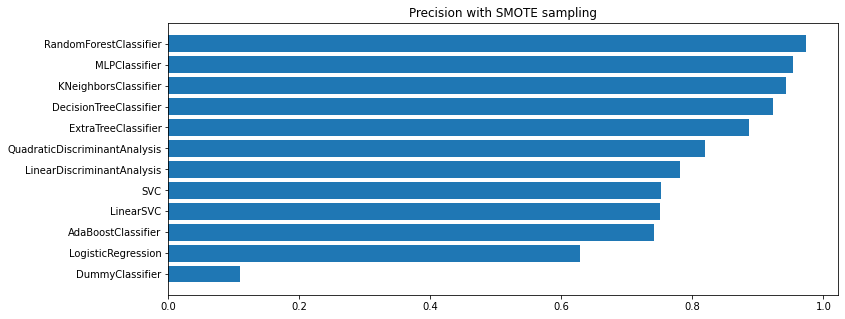

In [26]:
df_smote_sampling.sort_values(by=['precision'], inplace=True)
plt.barh(df_smote_sampling['algo'], df_smote_sampling['precision'])
plt.title("Precision with SMOTE sampling")
plt.savefig("run_all_multi_result_img/smote_precision.png", bbox_inches = 'tight')
plt.show()

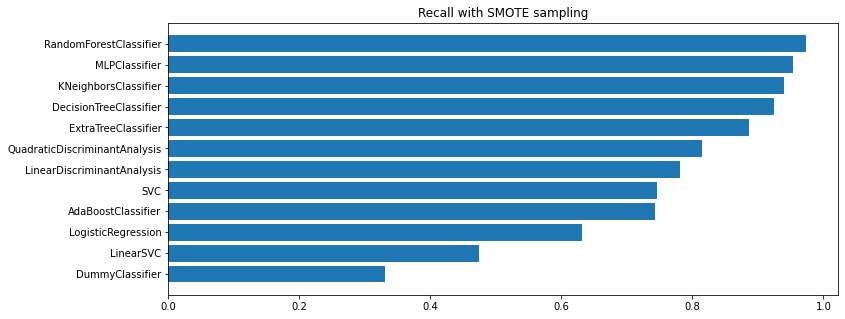

In [27]:
df_smote_sampling.sort_values(by=['recall'], inplace=True)
plt.barh(df_smote_sampling['algo'], df_smote_sampling['recall'])
plt.title("Recall with SMOTE sampling")
plt.savefig("run_all_multi_result_img/smote_recall.png", bbox_inches = 'tight')
plt.show()

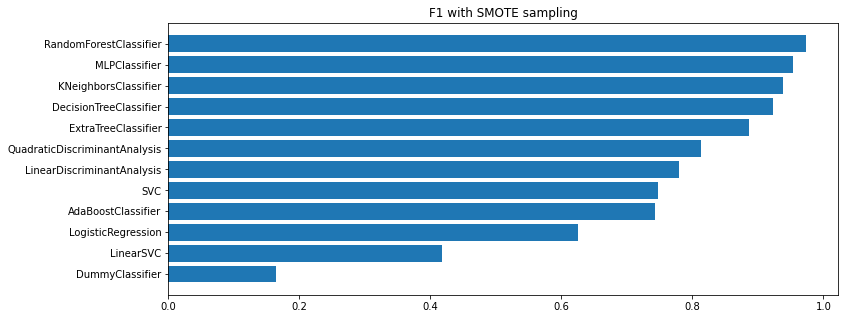

In [28]:
df_smote_sampling.sort_values(by=['f1'], inplace=True)
plt.barh(df_smote_sampling['algo'], df_smote_sampling['f1'])
plt.title("F1 with SMOTE sampling")
plt.savefig("run_all_multi_result_img/smote_precision.png", bbox_inches = 'tight')
plt.show()